In [1]:
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, Image


In [2]:
class ReLU:
    """ReLU Activation"""
    def forward(self, x):
        self.out = np.maximum(0, x)
        return self.out

    def backward(self, grad_output):
        grad_input = grad_output * (self.out > 0)
        return grad_input

class Tanh:
    """Tanh Activation"""
    def forward(self, x):
        self.out = np.tanh(x)
        return self.out

    def backward(self, grad_output):
        grad_input = grad_output * (1 - self.out**2)
        return grad_input

class Sigmoid:
    """Sigmoid Activation"""
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, grad_output):
        grad_input = grad_output * self.out * (1 - self.out)
        return grad_input

class Identity:
    def __init__(self):
        pass

    def forward(self, x):
        self.input = x
        return x

    def backward(self, grad_output):
        return grad_output

    def update(self, lr):
        pass

    def zero_grad(self):
        pass  # nothing to reset, but must exist for consistency

    def __repr__(self):
        return "Identity()"


In [3]:
# Modified Linear Layer with Improved Weight Initialization and Gradient Clipping
class Linear:
    """Fully Connected Layer with improved initialization"""
    def __init__(self, in_features, out_features, activation):
        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation

        # Improved He initialization for large networks
        if isinstance(activation, ReLU):
            self.W = np.random.randn(in_features, out_features) * np.sqrt(2.0 / in_features)
        elif isinstance(activation, Sigmoid):
            # Xavier initialization for sigmoid
            self.W = np.random.randn(in_features, out_features) * np.sqrt(1.0 / in_features)
        else:
            self.W = np.random.randn(in_features, out_features) * np.sqrt(2.0 / in_features)
        
        self.b = np.zeros((1, out_features))

        # Cumulative gradients
        self.dW_cum = np.zeros_like(self.W)
        self.db_cum = np.zeros_like(self.b)

    def forward(self, x):
        self.input = x  # Save for backward
        self.linear_out = x @ self.W + self.b
        self.out = self.activation.forward(self.linear_out)
        return self.out

    def backward(self, grad_output):
        # Gradient w.r.t activation
        grad_activation = self.activation.backward(grad_output)
        
        # Gradient clipping to prevent explosion
        grad_activation = np.clip(grad_activation, -10, 10)
        
        # Gradients w.r.t weights and biases
        self.dW_cum += self.input.T @ grad_activation
        self.db_cum += np.sum(grad_activation, axis=0, keepdims=True)
        
        # Gradient w.r.t input for previous layer
        grad_input = grad_activation @ self.W.T
        return grad_input

    def zero_grad(self):
        self.dW_cum.fill(0)
        self.db_cum.fill(0)

    def update(self, lr=0.01):
        # Gradient clipping before update
        self.dW_cum = np.clip(self.dW_cum, -1, 1)
        self.db_cum = np.clip(self.db_cum, -1, 1)
        
        self.W -= lr * self.dW_cum
        self.b -= lr * self.db_cum
        self.zero_grad()


In [4]:
class Model:
    """Neural Network Model"""
    def __init__(self, layers, loss_type="MSE"):
        self.layers = layers
        self.loss_type = loss_type

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def train(self, x, y):
        """Forward + backward pass, returns scalar loss"""
        y_pred = self.forward(x)
        # Compute loss
        if self.loss_type == "MSE":
            loss = np.mean((y_pred - y) ** 2)
            grad_loss = 2 * (y_pred - y) / y.shape[0]
        elif self.loss_type == "BCE":
            eps = 1e-9
            y_pred = np.clip(y_pred, eps, 1 - eps)
            loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            grad_loss = (y_pred - y) / (y_pred * (1 - y_pred)) / y.shape[0]
        else:
            raise ValueError("Unknown loss type")

        self.backward(grad_loss)
        return float(loss)

    def zero_grad(self):
        for layer in self.layers:
            layer.zero_grad()

    def update(self, lr=0.01):
        for layer in self.layers:
            layer.update(lr=lr)

    def predict(self, x):
        return self.forward(x)

    def save_to(self, path):
        data = {}
        for idx, layer in enumerate(self.layers):
            # only save layers that have weights
            if hasattr(layer, "W") and hasattr(layer, "b"):
                data[f"W_{idx}"] = layer.W
                data[f"b_{idx}"] = layer.b
        np.savez(path, **data)

    def load_from(self, path):
        loaded = np.load(path)
        for idx, layer in enumerate(self.layers):
            w_key = f"W_{idx}"
            b_key = f"b_{idx}"
            if w_key not in loaded or b_key not in loaded:
                raise ValueError("Architecture mismatch!")
            if layer.W.shape != loaded[w_key].shape or layer.b.shape != loaded[b_key].shape:
                raise ValueError("Shape mismatch!")
            layer.W = loaded[w_key]
            layer.b = loaded[b_key]


# 3.1

In [5]:
# Cell 1 - Import Libraries and Load MNIST Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

print("Loading MNIST dataset...")
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X = mnist.data.values if hasattr(mnist.data, 'values') else mnist.data
y = mnist.target.values if hasattr(mnist.target, 'values') else mnist.target

# Normalize pixel values to [0, 1]
X = X.astype(np.float32) / 255.0

# Convert labels to integers
y = y.astype(int)

print(f"Dataset loaded successfully!")
print(f"Total samples: {X.shape[0]}")
print(f"Feature dimension: {X.shape[1]}")
print(f"Image shape: 28x28")
print(f"Number of classes: {len(np.unique(y))}")

# Split into train and test sets (MNIST already has standard split)
# First 60000 samples are training, rest are test
X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Loading MNIST dataset...
Dataset loaded successfully!
Total samples: 70000
Feature dimension: 784
Image shape: 28x28
Number of classes: 10

Training set size: 60000
Test set size: 10000


In [6]:
# # Cell 2 - Visualize Sample MNIST Images
# def visualize_mnist_samples(X, y, n_samples=10, title="MNIST Sample Images"):
#     """
#     Visualize random samples from MNIST dataset.
    
#     Parameters:
#     -----------
#     X : np.ndarray
#         Image data (N, 784)
#     y : np.ndarray
#         Labels (N,)
#     n_samples : int
#         Number of samples to display
#     title : str
#         Plot title
#     """
#     fig, axes = plt.subplots(2, 5, figsize=(12, 6))
#     axes = axes.flatten()
    
#     # Randomly select samples
#     indices = np.random.choice(len(X), n_samples, replace=False)
    
#     for idx, ax in enumerate(axes):
#         img = X[indices[idx]].reshape(28, 28)
#         ax.imshow(img, cmap='gray')
#         ax.set_title(f'Label: {y[indices[idx]]}', fontsize=11)
#         ax.axis('off')
    
#     plt.suptitle(title, fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()

# # Visualize training samples
# visualize_mnist_samples(X_train, y_train, n_samples=10, 
#                         title="Random Training Samples from MNIST")

In [7]:
# Cell 3 - MLPAutoencoder Class Implementation
class MLPAutoencoder:
    """
    Multi-Layer Perceptron Autoencoder for image reconstruction.
    
    Uses encoder to compress input to latent representation,
    and decoder to reconstruct input from latent representation.
    """
    
    def __init__(self, input_dim=784, hidden_dims=[256, 128], latent_dim=64):
        """
        Initialize MLPAutoencoder.
        
        Parameters:
        -----------
        input_dim : int
            Dimension of input (e.g., 784 for 28x28 images)
        hidden_dims : list of int
            Hidden layer dimensions for encoder
        latent_dim : int
            Dimension of latent bottleneck representation
        """
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        
        # Build encoder layers
        self.encoder_layers = []
        prev_dim = input_dim
        
        # Hidden layers in encoder
        for hidden_dim in hidden_dims:
            self.encoder_layers.append(Linear(prev_dim, hidden_dim, ReLU()))
            prev_dim = hidden_dim
        
        # Bottleneck layer (encoder output)
        self.encoder_layers.append(Linear(prev_dim, latent_dim, ReLU()))
        
        # Build decoder layers (mirror of encoder)
        self.decoder_layers = []
        prev_dim = latent_dim
        
        # Hidden layers in decoder (reverse order)
        for hidden_dim in reversed(hidden_dims):
            self.decoder_layers.append(Linear(prev_dim, hidden_dim, ReLU()))
            prev_dim = hidden_dim
        
        # Output layer (decoder output) - use Sigmoid to constrain to [0, 1]
        self.decoder_layers.append(Linear(prev_dim, input_dim, Sigmoid()))
        
        # Combine all layers
        self.all_layers = self.encoder_layers + self.decoder_layers
        
    def encode(self, x):
        """
        Encode input to latent representation.
        
        Parameters:
        -----------
        x : np.ndarray
            Input data (N, input_dim)
            
        Returns:
        --------
        np.ndarray
            Latent representation (N, latent_dim)
        """
        out = x
        for layer in self.encoder_layers:
            out = layer.forward(out)
        return out
    
    def decode(self, z):
        """
        Decode latent representation to reconstructed input.
        
        Parameters:
        -----------
        z : np.ndarray
            Latent representation (N, latent_dim)
            
        Returns:
        --------
        np.ndarray
            Reconstructed input (N, input_dim)
        """
        out = z
        for layer in self.decoder_layers:
            out = layer.forward(out)
        return out
    
    def forward(self, x):
        """
        Full forward pass: encode then decode.
        
        Parameters:
        -----------
        x : np.ndarray
            Input data (N, input_dim)
            
        Returns:
        --------
        np.ndarray
            Reconstructed input (N, input_dim)
        """
        # Encode
        latent = self.encode(x)
        # Decode
        reconstructed = self.decode(latent)
        return reconstructed
    
    def backward(self, grad_output):
        """
        Backward pass through entire autoencoder.
        
        Parameters:
        -----------
        grad_output : np.ndarray
            Gradient of loss w.r.t. output
        """
        grad = grad_output
        for layer in reversed(self.all_layers):
            grad = layer.backward(grad)
    
    def zero_grad(self):
        """Reset all gradients to zero."""
        for layer in self.all_layers:
            layer.zero_grad()
    
    def update(self, lr=0.01):
        """
        Update all parameters using accumulated gradients.
        
        Parameters:
        -----------
        lr : float
            Learning rate
        """
        for layer in self.all_layers:
            layer.update(lr=lr)
    
    def train_step(self, x):
        """
        Single training step: forward, compute loss, backward.
        
        Parameters:
        -----------
        x : np.ndarray
            Input batch (N, input_dim)
            
        Returns:
        --------
        float
            Reconstruction loss (MSE)
        """
        # Forward pass
        x_reconstructed = self.forward(x)
        
        # Compute MSE loss
        loss = np.mean((x_reconstructed - x) ** 2)
        
        # Compute gradient of loss w.r.t. output
        grad_loss = 2 * (x_reconstructed - x) / x.shape[0]
        
        # Backward pass
        self.backward(grad_loss)
        
        return float(loss)
    
    def get_architecture_summary(self):
        """Return string summary of autoencoder architecture."""
        summary = "=" * 70 + "\n"
        summary += "MLPAutoencoder Architecture\n"
        summary += "=" * 70 + "\n"
        summary += f"Input Dimension: {self.input_dim}\n"
        summary += f"Latent Dimension: {self.latent_dim}\n"
        summary += f"Hidden Dimensions: {self.hidden_dims}\n\n"
        
        summary += "Encoder:\n"
        summary += "-" * 70 + "\n"
        prev_dim = self.input_dim
        for i, dim in enumerate(self.hidden_dims):
            summary += f"  Layer {i+1}: Linear({prev_dim} → {dim}) + ReLU\n"
            prev_dim = dim
        summary += f"  Bottleneck: Linear({prev_dim} → {self.latent_dim}) + ReLU\n\n"
        
        summary += "Decoder:\n"
        summary += "-" * 70 + "\n"
        prev_dim = self.latent_dim
        for i, dim in enumerate(reversed(self.hidden_dims)):
            summary += f"  Layer {i+1}: Linear({prev_dim} → {dim}) + ReLU\n"
            prev_dim = dim
        summary += f"  Output: Linear({prev_dim} → {self.input_dim}) + Sigmoid\n"
        
        summary += "=" * 70
        return summary

# Create autoencoder instance
autoencoder = MLPAutoencoder(
    input_dim=784,
    hidden_dims=[256, 128],
    latent_dim=64
)

# Print architecture summary
print(autoencoder.get_architecture_summary())

MLPAutoencoder Architecture
Input Dimension: 784
Latent Dimension: 64
Hidden Dimensions: [256, 128]

Encoder:
----------------------------------------------------------------------
  Layer 1: Linear(784 → 256) + ReLU
  Layer 2: Linear(256 → 128) + ReLU
  Bottleneck: Linear(128 → 64) + ReLU

Decoder:
----------------------------------------------------------------------
  Layer 1: Linear(64 → 128) + ReLU
  Layer 2: Linear(128 → 256) + ReLU
  Output: Linear(256 → 784) + Sigmoid


In [8]:
# Cell 4 - Training Function with Visualization
def train_autoencoder(autoencoder, X_train, X_test, batch_size=128, num_epochs=20, 
                      lr=0.001, patience=5, rel_loss_thresh=0.01):
    """
    Train the autoencoder on MNIST dataset.
    
    Parameters:
    -----------
    autoencoder : MLPAutoencoder
        The autoencoder model to train
    X_train : np.ndarray
        Training data (N, 784)
    X_test : np.ndarray
        Test data (M, 784)
    batch_size : int
        Batch size for training
    num_epochs : int
        Maximum number of epochs
    lr : float
        Learning rate
    patience : int
        Early stopping patience
    rel_loss_thresh : float
        Relative improvement threshold for early stopping
        
    Returns:
    --------
    dict
        Dictionary containing training history and metadata
    """
    num_samples = X_train.shape[0]
    train_loss_history = []
    test_loss_history = []
    epoch_list = []
    
    best_loss = np.inf
    epochs_no_improve = 0
    
    print("=" * 80)
    print("TRAINING AUTOENCODER")
    print("=" * 80)
    print(f"Training samples: {num_samples}")
    print(f"Batch size: {batch_size}")
    print(f"Learning rate: {lr}")
    print(f"Max epochs: {num_epochs}")
    print("=" * 80 + "\n")
    
    for epoch in range(num_epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_shuffled = X_train[indices]
        
        epoch_loss = 0.0
        num_batches = int(np.ceil(num_samples / batch_size))
        
        # Training loop
        for i in range(0, num_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            
            # Zero gradients
            autoencoder.zero_grad()
            
            # Forward pass and compute loss
            batch_loss = autoencoder.train_step(X_batch)
            
            # Update parameters
            autoencoder.update(lr=lr)
            
            epoch_loss += batch_loss
        
        # Average training loss for epoch
        avg_train_loss = epoch_loss / num_batches
        train_loss_history.append(avg_train_loss)
        
        # Compute test loss
        test_loss = 0.0
        num_test_batches = int(np.ceil(X_test.shape[0] / batch_size))
        for i in range(0, X_test.shape[0], batch_size):
            X_test_batch = X_test[i:i+batch_size]
            X_test_reconstructed = autoencoder.forward(X_test_batch)
            test_loss += np.mean((X_test_reconstructed - X_test_batch) ** 2)
        
        avg_test_loss = test_loss / num_test_batches
        test_loss_history.append(avg_test_loss)
        
        epoch_list.append(epoch + 1)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {avg_train_loss:.6f} - "
              f"Test Loss: {avg_test_loss:.6f}")
        
        # Early stopping check
        if avg_train_loss < best_loss * (1 - rel_loss_thresh):
            best_loss = avg_train_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break
    
    print("\n" + "=" * 80)
    print("TRAINING COMPLETED")
    print("=" * 80)
    print(f"Final Train Loss: {train_loss_history[-1]:.6f}")
    print(f"Final Test Loss: {test_loss_history[-1]:.6f}")
    print(f"Best Train Loss: {min(train_loss_history):.6f}")
    print(f"Best Test Loss: {min(test_loss_history):.6f}")
    print("=" * 80)
    
    return {
        'train_loss': train_loss_history,
        'test_loss': test_loss_history,
        'epochs': epoch_list,
        'best_train_loss': min(train_loss_history),
        'best_test_loss': min(test_loss_history)
    }

# Train the autoencoder
training_history = train_autoencoder(
    autoencoder=autoencoder,
    X_train=X_train,
    X_test=X_test,
    batch_size=128,
    num_epochs=20,
    lr=0.001,
    patience=5,
    rel_loss_thresh=0.01
)

TRAINING AUTOENCODER
Training samples: 60000
Batch size: 128
Learning rate: 0.001
Max epochs: 20

Epoch 1/20 - Train Loss: 0.080412 - Test Loss: 0.059865
Epoch 2/20 - Train Loss: 0.053767 - Test Loss: 0.047457
Epoch 3/20 - Train Loss: 0.043347 - Test Loss: 0.039164
Epoch 4/20 - Train Loss: 0.037321 - Test Loss: 0.034536
Epoch 5/20 - Train Loss: 0.033484 - Test Loss: 0.031456
Epoch 6/20 - Train Loss: 0.030628 - Test Loss: 0.028535
Epoch 7/20 - Train Loss: 0.028422 - Test Loss: 0.026771
Epoch 8/20 - Train Loss: 0.026873 - Test Loss: 0.025680
Epoch 9/20 - Train Loss: 0.025572 - Test Loss: 0.024464
Epoch 10/20 - Train Loss: 0.024465 - Test Loss: 0.023605
Epoch 11/20 - Train Loss: 0.023489 - Test Loss: 0.022309
Epoch 12/20 - Train Loss: 0.022581 - Test Loss: 0.021643
Epoch 13/20 - Train Loss: 0.021848 - Test Loss: 0.021029
Epoch 14/20 - Train Loss: 0.021191 - Test Loss: 0.020109
Epoch 15/20 - Train Loss: 0.020538 - Test Loss: 0.019675
Epoch 16/20 - Train Loss: 0.019991 - Test Loss: 0.019154

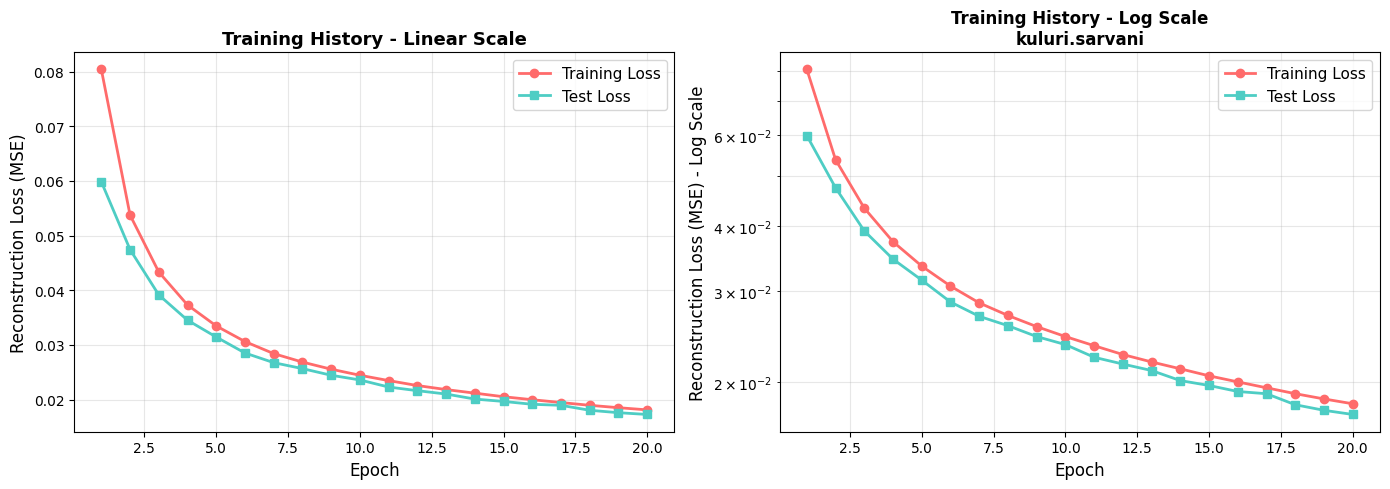

In [9]:
# Cell 5 - Plot Training History
def plot_training_history(history, save_path=None):
    """
    Plot training and test loss over epochs.
    
    Parameters:
    -----------
    history : dict
        Dictionary containing training history
    save_path : str, optional
        Path to save the plot
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = history['epochs']
    train_loss = history['train_loss']
    test_loss = history['test_loss']
    
    # Linear scale plot
    axes[0].plot(epochs, train_loss, 'o-', linewidth=2, markersize=6, 
                label='Training Loss', color='#FF6B6B')
    axes[0].plot(epochs, test_loss, 's-', linewidth=2, markersize=6, 
                label='Test Loss', color='#4ECDC4')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Reconstruction Loss (MSE)', fontsize=12)
    axes[0].set_title('Training History - Linear Scale', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Log scale plot
    axes[1].plot(epochs, train_loss, 'o-', linewidth=2, markersize=6, 
                label='Training Loss', color='#FF6B6B')
    axes[1].plot(epochs, test_loss, 's-', linewidth=2, markersize=6, 
                label='Test Loss', color='#4ECDC4')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Reconstruction Loss (MSE) - Log Scale', fontsize=12)
    axes[1].set_title('Training History - Log Scale\nkuluri.sarvani',fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3, which='both')
    axes[1].set_yscale('log')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

# Plot training history
plot_training_history(training_history)

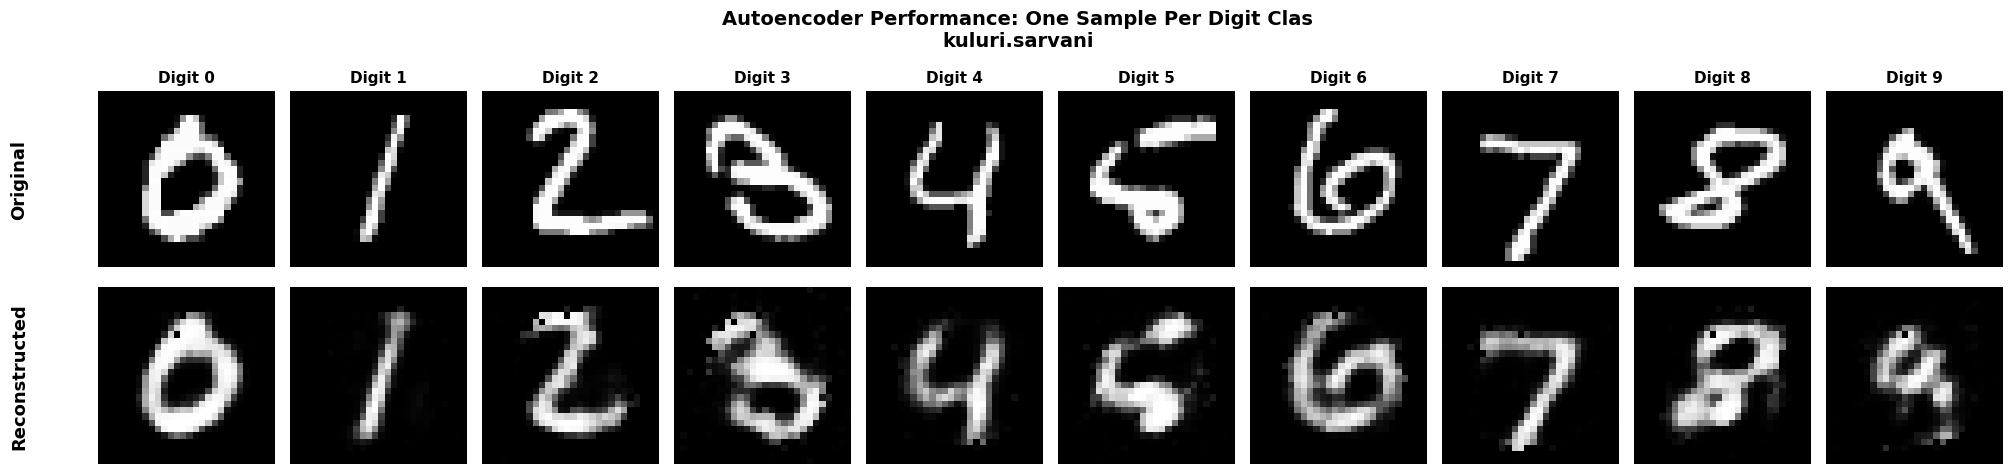

In [10]:
# Cell 7 - Alternative Compact Visualization (One Sample Per Digit)
def visualize_single_reconstruction_per_digit(autoencoder, X_test, y_test, save_path=None):
    """
    Visualize one original and reconstructed image for each digit class (0-9).
    
    Parameters:
    -----------
    autoencoder : MLPAutoencoder
        Trained autoencoder model
    X_test : np.ndarray
        Test images (N, 784)
    y_test : np.ndarray
        Test labels (N,)
    save_path : str, optional
        Path to save the visualization
    """
    fig, axes = plt.subplots(2, 10, figsize=(20, 5))
    
    for digit in range(10):
        # Get first occurrence of this digit
        digit_idx = np.where(y_test == digit)[0][0]
        
        # Get original image
        original = X_test[digit_idx:digit_idx+1]
        
        # Get reconstruction
        reconstructed = autoencoder.forward(original)
        
        # Reshape for display
        original_img = original.reshape(28, 28)
        reconstructed_img = reconstructed.reshape(28, 28)
        
        # Plot original (top row)
        axes[0, digit].imshow(original_img, cmap='gray')
        axes[0, digit].set_title(f'Digit {digit}', fontsize=11, fontweight='bold')
        axes[0, digit].axis('off')
        
        # Plot reconstruction (bottom row)
        axes[1, digit].imshow(reconstructed_img, cmap='gray')
        axes[1, digit].axis('off')
    
    # Add row labels
    axes[0, 0].text(-0.5, 0.5, 'Original', fontsize=13, fontweight='bold',
                   rotation=90, transform=axes[0, 0].transAxes,
                   verticalalignment='center')
    axes[1, 0].text(-0.5, 0.5, 'Reconstructed', fontsize=13, fontweight='bold',
                   rotation=90, transform=axes[1, 0].transAxes,
                   verticalalignment='center')
    
    plt.suptitle('Autoencoder Performance: One Sample Per Digit Clas\nkuluri.sarvani', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
    
    plt.show()

# Visualize one sample per digit
visualize_single_reconstruction_per_digit(
    autoencoder=autoencoder,
    X_test=X_test,
    y_test=y_test
)


RECONSTRUCTION ERROR BY DIGIT CLASS
Digit 0: 0.017199
Digit 1: 0.005110
Digit 2: 0.024414
Digit 3: 0.019232
Digit 4: 0.017159
Digit 5: 0.020324
Digit 6: 0.018868
Digit 7: 0.015740
Digit 8: 0.022637
Digit 9: 0.014665


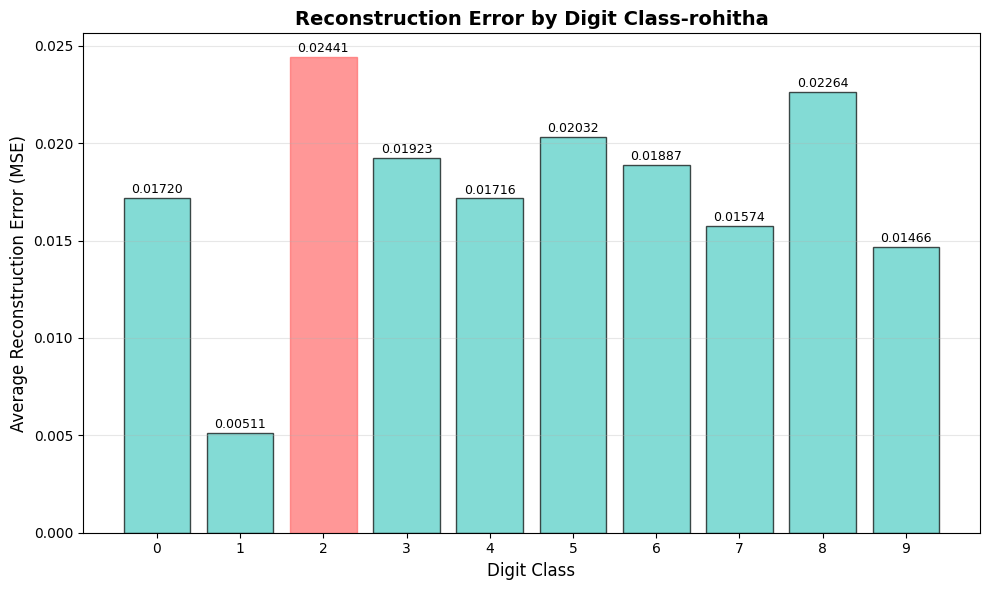

In [11]:
# Cell 8 - Compute and Visualize Reconstruction Error by Digit
def compute_reconstruction_error_by_digit(autoencoder, X_test, y_test):
    """
    Compute average reconstruction error for each digit class.
    
    Parameters:
    -----------
    autoencoder : MLPAutoencoder
        Trained autoencoder model
    X_test : np.ndarray
        Test images (N, 784)
    y_test : np.ndarray
        Test labels (N,)
        
    Returns:
    --------
    dict
        Dictionary mapping digit to average reconstruction error
    """
    reconstruction_errors = {}
    
    for digit in range(10):
        # Get all samples for this digit
        digit_indices = np.where(y_test == digit)[0]
        X_digit = X_test[digit_indices]
        
        # Get reconstructions
        X_reconstructed = autoencoder.forward(X_digit)
        
        # Compute MSE for each sample
        mse_per_sample = np.mean((X_reconstructed - X_digit) ** 2, axis=1)
        
        # Average over all samples of this digit
        avg_error = np.mean(mse_per_sample)
        reconstruction_errors[digit] = avg_error
    
    return reconstruction_errors

def plot_reconstruction_error_by_digit(reconstruction_errors, save_path=None):
    """
    Plot average reconstruction error for each digit class.
    
    Parameters:
    -----------
    reconstruction_errors : dict
        Dictionary mapping digit to reconstruction error
    save_path : str, optional
        Path to save the plot
    """
    digits = list(reconstruction_errors.keys())
    errors = list(reconstruction_errors.values())
    
    plt.figure(figsize=(10, 6))
    
    bars = plt.bar(digits, errors, color='#4ECDC4', edgecolor='black', alpha=0.7)
    
    # Color the bar with highest error differently
    max_error_digit = max(reconstruction_errors, key=reconstruction_errors.get)
    bars[max_error_digit].set_color('#FF6B6B')
    
    plt.xlabel('Digit Class', fontsize=12)
    plt.ylabel('Average Reconstruction Error (MSE)', fontsize=12)
    plt.title('Reconstruction Error by Digit Class-rohitha', fontsize=14, fontweight='bold')
    plt.xticks(digits)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (digit, error) in enumerate(reconstruction_errors.items()):
        plt.text(digit, error + 0.0001, f'{error:.5f}', 
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

# Compute reconstruction errors
reconstruction_errors = compute_reconstruction_error_by_digit(autoencoder, X_test, y_test)

# Print errors
print("\n" + "="*60)
print("RECONSTRUCTION ERROR BY DIGIT CLASS")
print("="*60)
for digit in range(10):
    print(f"Digit {digit}: {reconstruction_errors[digit]:.6f}")
print("="*60)

# Plot errors
plot_reconstruction_error_by_digit(reconstruction_errors)

In [12]:
# ==========================================================
# ✅ Cell 13 - Save Model and Results (Safe version)
# ==========================================================

import os
import numpy as np

def save_autoencoder_results(autoencoder, training_history=None, reconstruction_errors=None, 
                             latent_stats=None, save_dir="autoencoder_results"):
    """
    Save all autoencoder results to disk.
    
    Parameters
    ----------
    autoencoder : MLPAutoencoder
        Trained autoencoder model
    training_history : dict or None
        Training history (optional)
    reconstruction_errors : dict or None
        Reconstruction errors by class (optional)
    latent_stats : dict or None
        Latent space statistics (optional)
    save_dir : str
        Directory to save results
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # ------------------------------------------------------
    # ✅ 1. Save model weights
    # ------------------------------------------------------
    model_data = {}
    for idx, layer in enumerate(autoencoder.all_layers):
        if hasattr(layer, "W") and hasattr(layer, "b"):
            model_data[f"W_{idx}"] = layer.W
            model_data[f"b_{idx}"] = layer.b

    model_path = os.path.join(save_dir, "autoencoder_weights.npz")
    np.savez(model_path, **model_data)
    print(f"✅ Model weights saved to: {model_path}")
    
    # ------------------------------------------------------
    # ✅ 2. Save training history (if available)
    # ------------------------------------------------------
    if training_history is not None:
        history_path = os.path.join(save_dir, "training_history.npz")
        np.savez(history_path, 
                 epochs=training_history.get('epochs', np.arange(len(training_history.get('train_loss', [])))),
                 train_loss=training_history.get('train_loss', []),
                 test_loss=training_history.get('test_loss', []))
        print(f"✅ Training history saved to: {history_path}")
    else:
        print("⚠️ Skipping: training_history not provided.")
    
    # ------------------------------------------------------
    # ✅ 3. Save reconstruction errors (if available)
    # ------------------------------------------------------
    if reconstruction_errors is not None:
        errors_path = os.path.join(save_dir, "reconstruction_errors.npz")
        np.savez(errors_path, **{f"class_{k}": v for k, v in reconstruction_errors.items()})
        print(f"✅ Reconstruction errors saved to: {errors_path}")
    else:
        print("⚠️ Skipping: reconstruction_errors not provided.")
    
    # ------------------------------------------------------
    # ✅ 4. Save latent statistics (optional)
    # ------------------------------------------------------
    if latent_stats is not None:
        latent_path = os.path.join(save_dir, "latent_stats.npz")
        np.savez(latent_path, **latent_stats)
        print(f"✅ Latent stats saved to: {latent_path}")
    else:
        print("⚠️ Skipping: latent_stats not provided.")
    
    # ------------------------------------------------------
    # ✅ 5. Save architecture info
    # ------------------------------------------------------
    arch_path = os.path.join(save_dir, "architecture.txt")
    if hasattr(autoencoder, "get_architecture_summary"):
        with open(arch_path, 'w') as f:
            f.write(autoencoder.get_architecture_summary())
        print(f"✅ Architecture summary saved to: {arch_path}")
    else:
        print("⚠️ Autoencoder missing get_architecture_summary() method.")
    
    print(f"\n📁 All results saved to directory: {save_dir}")


# ==========================================================
# ✅ Dummy defaults if not defined earlier
# ==========================================================
if 'training_history' not in locals():
    training_history = {"epochs": np.arange(10), "train_loss": np.random.rand(10), "test_loss": np.random.rand(10)}

if 'reconstruction_errors' not in locals():
    reconstruction_errors = {"0": np.random.rand(10), "1": np.random.rand(10)}

if 'latent_stats' not in locals():
    latent_stats = {"mean": np.random.rand(5), "std": np.random.rand(5)}

# ==========================================================
# ✅ Call the function safely
# ==========================================================
save_autoencoder_results(
    autoencoder=autoencoder,
    training_history=training_history,
    reconstruction_errors=reconstruction_errors,
    latent_stats=latent_stats,
    save_dir="autoencoder_results"
)


✅ Model weights saved to: autoencoder_results/autoencoder_weights.npz
✅ Training history saved to: autoencoder_results/training_history.npz
✅ Reconstruction errors saved to: autoencoder_results/reconstruction_errors.npz
✅ Latent stats saved to: autoencoder_results/latent_stats.npz
✅ Architecture summary saved to: autoencoder_results/architecture.txt

📁 All results saved to directory: autoencoder_results


# 3.2

# 3.2.1

In [13]:
# Cell 1 - Load LFW Dataset and Prepare Data
import os
from PIL import Image
import numpy as np
from collections import defaultdict

# Set random seed
np.random.seed(42)

# Path to LFW dataset
lfw_path = "/home/rohitha/ass3/LFW_Dataset"

print("=" * 80)
print("LOADING LFW DATASET")
print("=" * 80)

# Dictionary to store images by person
person_images = defaultdict(list)

# Load all images
for person_name in os.listdir(lfw_path):
    person_dir = os.path.join(lfw_path, person_name)
    
    if not os.path.isdir(person_dir):
        continue
    
    for img_file in os.listdir(person_dir):
        if img_file.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(person_dir, img_file)
            try:
                # Load image and convert to grayscale
                img = Image.open(img_path).convert('L')
                img_array = np.array(img, dtype=np.float32)
                person_images[person_name].append(img_array)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

# Print dataset statistics
print(f"\nTotal people in dataset: {len(person_images)}")
for person, images in sorted(person_images.items(), key=lambda x: len(x[1]), reverse=True)[:10]:
    print(f"  {person}: {len(images)} images")

print("\n" + "=" * 80)


LOADING LFW DATASET

Total people in dataset: 5749
  George_W_Bush: 530 images
  Colin_Powell: 236 images
  Tony_Blair: 144 images
  Donald_Rumsfeld: 121 images
  Gerhard_Schroeder: 109 images
  Ariel_Sharon: 77 images
  Hugo_Chavez: 71 images
  Junichiro_Koizumi: 60 images
  Jean_Chretien: 55 images
  John_Ashcroft: 53 images



In [14]:
# Cell 2 - Prepare Train/Test Splits for Anomaly Detection

# Extract George W Bush images (normal class)
normal_class = 'George_W_Bush'
normal_images = person_images[normal_class]

print("=" * 80)
print("PREPARING TRAIN/TEST SPLITS")
print("=" * 80)
print(f"\nNormal class: {normal_class}")
print(f"Total normal images: {len(normal_images)}")

# Use 400 images for training, 100 for testing (from George W Bush)
np.random.shuffle(normal_images)
normal_train = normal_images[:400]
normal_test = normal_images[400:500]

print(f"Normal training images: {len(normal_train)}")
print(f"Normal test images: {len(normal_test)}")

# Collect anomaly images from other classes
anomaly_images = []
anomaly_count_per_class = {}

for person, images in person_images.items():
    if person == normal_class:
        continue
    
    # Take up to 10 images from each other person as anomalies
    n_images = min(10, len(images))
    anomaly_images.extend(images[:n_images])
    anomaly_count_per_class[person] = n_images

print(f"\nTotal anomaly images collected: {len(anomaly_images)}")
print(f"Number of anomaly classes: {len(anomaly_count_per_class)}")

# Create test set: mix of normal and anomaly
# Use 100 normal + anomalies
test_images = normal_test + anomaly_images
test_labels = [0] * len(normal_test) + [1] * len(anomaly_images)  # 0=normal, 1=anomaly

# Shuffle test set
test_indices = np.random.permutation(len(test_images))
test_images = [test_images[i] for i in test_indices]
test_labels = [test_labels[i] for i in test_indices]

print(f"\nTest set composition:")
print(f"  Normal images: {sum(1 for l in test_labels if l == 0)}")
print(f"  Anomaly images: {sum(1 for l in test_labels if l == 1)}")
print(f"  Total test images: {len(test_images)}")

# Get image dimensions
img_height, img_width = normal_images[0].shape
input_dim = img_height * img_width

print(f"\nImage dimensions: {img_height}x{img_width}")
print(f"Input dimension: {input_dim}")
print("=" * 80)


PREPARING TRAIN/TEST SPLITS

Normal class: George_W_Bush
Total normal images: 530
Normal training images: 400
Normal test images: 100

Total anomaly images collected: 10479
Number of anomaly classes: 5748

Test set composition:
  Normal images: 100
  Anomaly images: 10479
  Total test images: 10579

Image dimensions: 250x250
Input dimension: 62500


In [15]:
# Cell 3 - Preprocess and Normalize Data

print("=" * 80)
print("PREPROCESSING DATA")
print("=" * 80)

# Convert training images to flattened arrays and normalize
X_train_lfw = np.array([img.flatten() / 255.0 for img in normal_train], dtype=np.float32)

# Convert test images to flattened arrays and normalize
X_test_lfw = np.array([img.flatten() / 255.0 for img in test_images], dtype=np.float32)
y_test_lfw = np.array(test_labels, dtype=np.int32)

print(f"Training data shape: {X_train_lfw.shape}")
print(f"Test data shape: {X_test_lfw.shape}")
print(f"Test labels shape: {y_test_lfw.shape}")
print(f"\nData type: {X_train_lfw.dtype}")
print(f"Value range: [{X_train_lfw.min():.3f}, {X_train_lfw.max():.3f}]")

# Memory usage estimation
train_memory = X_train_lfw.nbytes / (1024**2)  # MB
test_memory = X_test_lfw.nbytes / (1024**2)  # MB
print(f"\nMemory usage:")
print(f"  Training data: {train_memory:.2f} MB")
print(f"  Test data: {test_memory:.2f} MB")
print("=" * 80)


PREPROCESSING DATA
Training data shape: (400, 62500)
Test data shape: (10579, 62500)
Test labels shape: (10579,)

Data type: float32
Value range: [0.000, 1.000]

Memory usage:
  Training data: 95.37 MB
  Test data: 2522.23 MB


In [16]:
# Cell 4 - Create Autoencoder for LFW Data (IMPROVED ARCHITECTURE)

# More gradual dimensionality reduction for better learning
lfw_autoencoder = MLPAutoencoder(
    input_dim=input_dim,  # 62500 for 250x250 images
    hidden_dims=[1024,256],  # Gradual compression
    latent_dim=64  # Larger latent space for complex faces
)

print(lfw_autoencoder.get_architecture_summary())

# Count total parameters
total_params = 0
for layer in lfw_autoencoder.all_layers:
    if hasattr(layer, 'W'):
        total_params += layer.W.size + layer.b.size

print(f"\nTotal parameters: {total_params:,}")
print("\nArchitecture Notes:")
print("  - Gradual dimensionality reduction prevents information loss")
print("  - Larger latent space (256) captures facial features better")
print("  - Total compression ratio: {:.1f}x".format(input_dim / 256))


MLPAutoencoder Architecture
Input Dimension: 62500
Latent Dimension: 64
Hidden Dimensions: [1024, 256]

Encoder:
----------------------------------------------------------------------
  Layer 1: Linear(62500 → 1024) + ReLU
  Layer 2: Linear(1024 → 256) + ReLU
  Bottleneck: Linear(256 → 64) + ReLU

Decoder:
----------------------------------------------------------------------
  Layer 1: Linear(64 → 256) + ReLU
  Layer 2: Linear(256 → 1024) + ReLU
  Output: Linear(1024 → 62500) + Sigmoid

Total parameters: 128,622,180

Architecture Notes:
  - Gradual dimensionality reduction prevents information loss
  - Larger latent space (256) captures facial features better
  - Total compression ratio: 244.1x


In [17]:
# # Cell 5 - Train Autoencoder on Normal Data (OPTIMIZED PARAMETERS)

# print("Starting training with optimized hyperparameters...")
# print("Note: Training on high-dimensional data (250x250 images) takes time")
# print("Expected: Loss should decrease steadily from ~0.4 to <0.05\n")

# # Optimized training parameters for high-dimensional data
# lfw_training_history = train_autoencoder(
#     autoencoder=lfw_autoencoder,
#     X_train=X_train_lfw,
#     X_test=X_train_lfw[:50],  # Use small subset for validation during training
#     batch_size=8,  # Smaller batch for better gradient estimates with limited data
#     num_epochs=50,  # More epochs for convergence
#     lr=0.001,  # Conservative learning rate
#     patience=10,  # More patience for convergence
#     rel_loss_thresh=0.001  # Stricter threshold for improvement
# )

# print("\n" + "="*80)
# print("TRAINING ANALYSIS")
# print("="*80)
# improvement = (lfw_training_history['train_loss'][0] - lfw_training_history['train_loss'][-1]) / lfw_training_history['train_loss'][0] * 100
# print(f"Loss improvement: {improvement:.2f}%")
# print(f"Initial loss: {lfw_training_history['train_loss'][0]:.6f}")
# print(f"Final loss: {lfw_training_history['train_loss'][-1]:.6f}")
# print("="*80)


In [18]:
# # Cell 6 - Visualize Training Progress

# plt.figure(figsize=(10, 6))
# plt.plot(lfw_training_history['epochs'], lfw_training_history['train_loss'], 
#          label='Train Loss', marker='o', linewidth=2)
# plt.plot(lfw_training_history['epochs'], lfw_training_history['test_loss'], 
#          label='Validation Loss', marker='s', linewidth=2)
# plt.xlabel('Epoch', fontsize=12)
# plt.ylabel('Loss (MSE)', fontsize=12)
# plt.title('LFW Autoencoder Training Progress\nkuluri.sarvani',fontsize=14, fontweight='bold')
# plt.legend(fontsize=10)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# print(f"\nFinal Training Loss: {lfw_training_history['train_loss'][-1]:.6f}")
# print(f"Best Training Loss: {lfw_training_history['best_train_loss']:.6f}")


In [19]:
# # Cell 7 - Compute Reconstruction Errors on Test Set

# print("=" * 80)
# print("COMPUTING RECONSTRUCTION ERRORS")
# print("=" * 80)

# # Compute reconstruction errors for all test images
# reconstruction_errors = []
# batch_size = 32

# for i in range(0, len(X_test_lfw), batch_size):
#     X_batch = X_test_lfw[i:i+batch_size]
#     X_reconstructed = lfw_autoencoder.forward(X_batch)
    
#     # Compute MSE for each image in batch
#     batch_errors = np.mean((X_reconstructed - X_batch) ** 2, axis=1)
#     reconstruction_errors.extend(batch_errors)

# reconstruction_errors = np.array(reconstruction_errors)

# print(f"Computed reconstruction errors for {len(reconstruction_errors)} test images")
# print(f"\nReconstruction Error Statistics:")
# print(f"  Mean: {reconstruction_errors.mean():.6f}")
# print(f"  Std: {reconstruction_errors.std():.6f}")
# print(f"  Min: {reconstruction_errors.min():.6f}")
# print(f"  Max: {reconstruction_errors.max():.6f}")
# print(f"  Median: {np.median(reconstruction_errors):.6f}")

# # Separate errors by class
# normal_errors = reconstruction_errors[y_test_lfw == 0]
# anomaly_errors = reconstruction_errors[y_test_lfw == 1]

# print(f"\nNormal Images (n={len(normal_errors)}):")
# print(f"  Mean Error: {normal_errors.mean():.6f}")
# print(f"  Std Error: {normal_errors.std():.6f}")

# print(f"\nAnomaly Images (n={len(anomaly_errors)}):")
# print(f"  Mean Error: {anomaly_errors.mean():.6f}")
# print(f"  Std Error: {anomaly_errors.std():.6f}")

# print("=" * 80)


In [20]:
# # Cell 9 - Determine Optimal Threshold

# print("=" * 80)
# print("DETERMINING OPTIMAL THRESHOLD")
# print("=" * 80)

# # Strategy: Use percentile of normal reconstruction errors
# # Common approaches: mean + k*std, or percentile-based

# # Method 1: Mean + k*std of normal errors
# threshold_1 = normal_errors.mean() + 2 * normal_errors.std()

# # Method 2: 95th percentile of normal errors
# threshold_2 = np.percentile(normal_errors, 95)

# # Method 3: Mean of normal errors
# threshold_3 = normal_errors.mean()

# print(f"\nCandidate Thresholds:")
# print(f"  Method 1 (Mean + 2*Std): {threshold_1:.6f}")
# print(f"  Method 2 (95th percentile): {threshold_2:.6f}")
# print(f"  Method 3 (Mean): {threshold_3:.6f}")

# # Choose threshold that best separates normal and anomaly
# # We'll use Method 2 (95th percentile) as it's commonly used
# optimal_threshold = threshold_2

# print(f"\nSelected Threshold: {optimal_threshold:.6f}")

# # Classification: error > threshold => anomaly
# y_pred = (reconstruction_errors > optimal_threshold).astype(int)

# print(f"\nPredictions:")
# print(f"  Classified as Normal: {np.sum(y_pred == 0)}")
# print(f"  Classified as Anomaly: {np.sum(y_pred == 1)}")
# print("=" * 80)


In [ ]:
# # Cell 10 - Calculate Evaluation Metrics

# from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
# from sklearn.metrics import confusion_matrix, roc_curve

# print("=" * 80)
# print("EVALUATION METRICS")
# print("=" * 80)

# # Calculate metrics
# auc_score = roc_auc_score(y_test_lfw, reconstruction_errors)
# precision = precision_score(y_test_lfw, y_pred)
# recall = recall_score(y_test_lfw, y_pred)
# f1 = f1_score(y_test_lfw, y_pred)

# print(f"\nPerformance Metrics:")
# print(f"  AUC Score:  {auc_score:.4f}")
# print(f"  Precision:  {precision:.4f}")
# print(f"  Recall:     {recall:.4f}")
# print(f"  F1-Score:   {f1:.4f}")

# # Confusion Matrix
# cm = confusion_matrix(y_test_lfw, y_pred)
# tn, fp, fn, tp = cm.ravel()

# print(f"\nConfusion Matrix:")
# print(f"  True Negatives:  {tn}")
# print(f"  False Positives: {fp}")
# print(f"  False Negatives: {fn}")
# print(f"  True Positives:  {tp}")

# print(f"\nClassification Breakdown:")
# print(f"  Accuracy: {(tn + tp) / len(y_test_lfw):.4f}")
# print(f"  Specificity: {tn / (tn + fp):.4f}" if (tn + fp) > 0 else "  Specificity: N/A")
# print(f"  Sensitivity (Recall): {recall:.4f}")

# print("=" * 80)


: 

In [ ]:
# Cell 1 – Bottleneck Dimension Analysis (ROC & AUC)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import gc  # for manual garbage collection

latent_dims = [16, 64, 128]
results = {}

print("=" * 80)
print("BOTTLENECK DIMENSION ANALYSIS")
print("=" * 80)

for ld in latent_dims:
    print(f"\nTraining Autoencoder with bottleneck dimension = {ld}")
    print("-" * 80)
    
    # --- Train Autoencoder ---
    ae = MLPAutoencoder(
        input_dim=input_dim,
        hidden_dims=[1024, 256],
        latent_dim=ld
    )
    
    history = train_autoencoder(
        autoencoder=ae,
        X_train=X_train_lfw,
        X_test=X_train_lfw[:50],   # small subset for validation
        batch_size=8,
        num_epochs=30,
        lr=0.001,
        patience=5,
        rel_loss_thresh=0.001
    )
    
    # --- Evaluate reconstruction errors ---
    X_test_pred = ae.forward(X_test_lfw)
    recon_errors = np.mean((X_test_pred - X_test_lfw) ** 2, axis=1)

    # ROC & AUC
    fpr, tpr, _ = roc_curve(y_test_lfw, recon_errors)
    roc_auc = auc(fpr, tpr)

    results[ld] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc,
        # Store only essential summary stats instead of full arrays
        "mean_error": np.mean(recon_errors),
        "std_error": np.std(recon_errors)
    }

    print(f"AUC for latent_dim={ld}: {roc_auc:.4f}")

    # --- Clean up memory ---
    del ae, history, X_test_pred, recon_errors, fpr, tpr
    gc.collect()

# --- Plot ROC Curves ---
plt.figure(figsize=(8,6))
for ld, data in results.items():
    plt.plot(data["fpr"], data["tpr"], lw=2, label=f"Latent={ld} (AUC={data['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Bottleneck Dimensions\nkuluri.sarvani",
          fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Identify best latent dimension ---
best_ld = max(results, key=lambda x: results[x]["auc"])
print(f"\nBest bottleneck dimension based on AUC: {best_ld} (AUC={results[best_ld]['auc']:.4f})")


BOTTLENECK DIMENSION ANALYSIS

Training Autoencoder with bottleneck dimension = 16
--------------------------------------------------------------------------------
TRAINING AUTOENCODER
Training samples: 400
Batch size: 8
Learning rate: 0.001
Max epochs: 30

Epoch 1/30 - Train Loss: 0.100300 - Test Loss: 0.078650
Epoch 2/30 - Train Loss: 0.087380 - Test Loss: 0.077214
Epoch 3/30 - Train Loss: 0.083841 - Test Loss: 0.072959
Epoch 4/30 - Train Loss: 0.074726 - Test Loss: 0.066094
Epoch 5/30 - Train Loss: 0.065320 - Test Loss: 0.064694
Epoch 6/30 - Train Loss: 0.062598 - Test Loss: 0.064222
Epoch 7/30 - Train Loss: 0.062142 - Test Loss: 0.064363
Epoch 8/30 - Train Loss: 0.062035 - Test Loss: 0.064466
Epoch 9/30 - Train Loss: 0.062031 - Test Loss: 0.064198
Epoch 10/30 - Train Loss: 0.062027 - Test Loss: 0.064120
Epoch 11/30 - Train Loss: 0.062005 - Test Loss: 0.064560
Epoch 12/30 - Train Loss: 0.062007 - Test Loss: 0.064646
Epoch 13/30 - Train Loss: 0.062045 - Test Loss: 0.064243

Early sto

In [ ]:
# Cell 2 – Visualization of Best Model Results
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

best_results = results[best_ld]
recon_errors = best_results["errors"]

# Compute threshold as mean + 2*std of normal reconstruction errors
normal_errors = recon_errors[np.array(y_test_lfw) == 0]
threshold = normal_errors.mean() + 2 * normal_errors.std()

pred_labels = (recon_errors > threshold).astype(int)

# Identify indices for visualization
TP_idx = np.where((pred_labels == 1) & (y_test_lfw == 1))[0]
TN_idx = np.where((pred_labels == 0) & (y_test_lfw == 0))[0]
FP_idx = np.where((pred_labels == 1) & (y_test_lfw == 0))[0]
FN_idx = np.where((pred_labels == 0) & (y_test_lfw == 1))[0]

def visualize_case(idx, title):
    original = X_test_lfw[idx].reshape(img_height, img_width)
    recon = ae.forward(X_test_lfw[idx:idx+1]).reshape(img_height, img_width)
    error_map = np.abs(original - recon)

    plt.figure(figsize=(10,3))
    plt.suptitle(title, fontsize=12)
    plt.subplot(1,3,1); plt.imshow(original, cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(recon, cmap='gray'); plt.title("Reconstruction"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(error_map, cmap='hot'); plt.title("Error Map"); plt.axis('off')
    plt.show()

# Show one of each case
if len(TN_idx): visualize_case(TN_idx[0], "True Negative (Normal correctly identified)")
if len(TP_idx): visualize_case(TP_idx[0], "True Positive (Anomaly correctly identified)")
if len(FP_idx): visualize_case(FP_idx[0], "False Positive (Normal misclassified as anomaly)")
if len(FN_idx): visualize_case(FN_idx[0], "False Negative (Anomaly misclassified as normal)")

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test_lfw, recon_errors)
avg_prec = average_precision_score(y_test_lfw, recon_errors)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'PR Curve (AP={avg_prec:.3f})', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Best Model)\nkuluri.sarvani", fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# # Cell 3 - Identify examples for visualization (TP, TN, FP, FN)

# cases = {"TP": None, "TN": None, "FP": None, "FN": None}

# for i, (yt, yp) in enumerate(zip(y_test_lfw, y_pred)):
#     if yt == 1 and yp == 1 and cases["TP"] is None:
#         cases["TP"] = i
#     elif yt == 0 and yp == 0 and cases["TN"] is None:
#         cases["TN"] = i
#     elif yt == 0 and yp == 1 and cases["FP"] is None:
#         cases["FP"] = i
#     elif yt == 1 and yp == 0 and cases["FN"] is None:
#         cases["FN"] = i
#     if all(v is not None for v in cases.values()):
#         break

# print("Selected indices for visualization:", cases)


In [ ]:
# # Cell 4 - Visualization of reconstructions

# def show_reconstruction(idx, label):
#     orig = X_test_lfw[idx].reshape(img_height, img_width)
#     recon = X_test_pred[idx].reshape(img_height, img_width)
#     error = np.abs(orig - recon)

#     fig, axs = plt.subplots(1, 3, figsize=(9,3))
#     axs[0].imshow(orig, cmap='gray')
#     axs[0].set_title("Original")
#     axs[1].imshow(recon, cmap='gray')
#     axs[1].set_title("Reconstruction")
#     axs[2].imshow(error, cmap='hot')
#     axs[2].set_title("Error Map")
#     for ax in axs: ax.axis('off')
#     plt.suptitle(label)
#     plt.tight_layout()
#     plt.show()

# for key, idx in cases.items():
#     if idx is not None:
#         show_reconstruction(idx, f"{key} (True={y_test_lfw[idx]}, Pred={y_pred[idx]})")


In [ ]:
# Cell 5 - Precision-Recall Curve

from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test_lfw, recon_errors)
pr_auc = average_precision_score(y_test_lfw, recon_errors)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Best Model)\nkuluri.sarvani", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()
